In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from display_xml import XML
import CLB.CLBXMLWriter as CLBXML   
from skimage import measure


[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.03926991  0.03926991  0.03926991 ...  0.03926991  0.03926991
   0.03926991]
 [ 0.07853982  0.07853982  0.07853982 ...  0.07853982  0.07853982
   0.07853982]
 ...
 [-0.11780972 -0.11780972 -0.11780972 ... -0.11780972 -0.11780972
  -0.11780972]
 [-0.07853982 -0.07853982 -0.07853982 ... -0.07853982 -0.07853982
  -0.07853982]
 [-0.03926991 -0.03926991 -0.03926991 ... -0.03926991 -0.03926991
  -0.03926991]]


<Figure size 720x720 with 0 Axes>

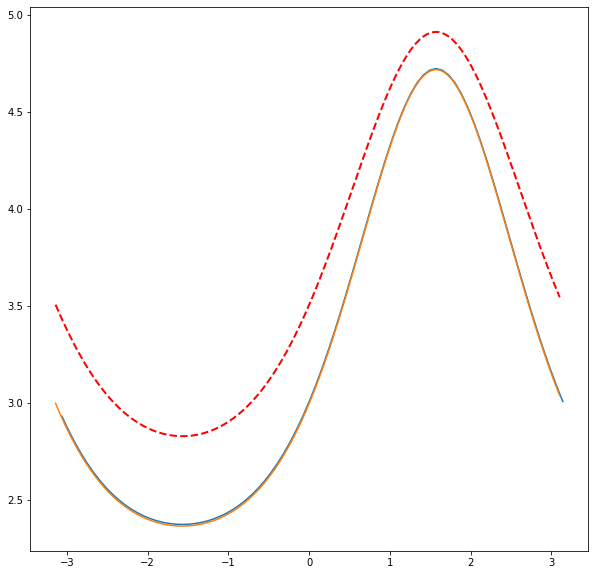

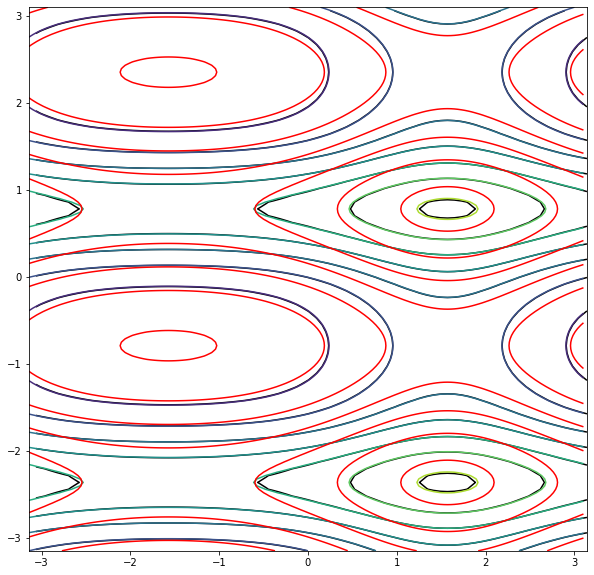

In [51]:
def fft_sol(initial_condition, diffusivity, lambda_phi, time):
    L = initial_condition.shape[0]
    x = np.linspace(0, L-1, L)      # columns (Width)
    y = np.linspace(0, L-1, L)      # rows (Height)
    [X,Y] = np.meshgrid(x,y)
    xnorm = X / L * 2 * np.pi
    ynorm = Y / L * 2 * np.pi
    
    _diffusivity = diffusivity * (L /( 2 * np.pi))**2
    
    F = np.fft.fft2(initial_condition)   
    n = L
    x2 = np.array([ float(i) if i < n/2 else float(-(n-i)) for i in range(0,n)])
    k2, k1 = np.meshgrid(x2, x2)
    k1 *= 2.*np.pi/L
    k2 *= 2.*np.pi/L
    print(k1)
    tmp = -time*(_diffusivity*(k1**2+ k2**2 ) + lambda_phi)
    decay = np.exp(tmp)
    yinv = np.fft.ifft2(np.multiply(F,decay))
    P = np.real(yinv) # ignore imaginary artifacts
    return P


i = 0
f = h5py.File('./output/LinearReaction_HDF5_%08d.h5'%i)    
Nlb = len(f['PHI'][0,0,:])
xlb = np.arange(0,Nlb)
xlb = (xlb )/ (Nlb) * 2 * np.pi
Xlb,Ylb = np.meshgrid(xlb,xlb)

Xlb = np.pi - Xlb
Ylb = Ylb - np.pi


plt.figure(figsize=(10,10))

Nfft = 161
lx = np.linspace(-np.pi,np.pi,Nfft)[:-1]
X,Y = np.meshgrid(lx,lx)
F0 = np.exp(np.sin(X)) + 2*np.exp(np.sin(2*Y))

F1 = fft_sol(F0, .1, 0., 1.)


plt.figure(figsize=(10,10))
plt.plot(Xlb[0,:],f['PHI'][0,0,:])
plt.plot(X[0,:],F[0,:])
plt.plot(X[0,:],F1[0,:], 'r--', lw=2)


plt.figure(figsize=(10,10))
plt.contour(Xlb,Ylb,f['PHI'][0,:,:], colors='k')
plt.contour(X,Y,F0[:,:])
plt.contour(X,Y,F1[:,:], colors='r')


In [457]:
shapes_trapez = list()
shapes_heun = list()
shapes_euler = list()
shapes_midpoint = list()

factors = [8]
spatial = True

for factor in factors:
    if spatial:
        time_factor = factor#**2
        space_factor = factor
    else:
        time_factor = factor
        space_factor = 1
    
    
    
    domain_size = 10 * space_factor
    time = 100 * time_factor

    CLBc = CLBXML.CLBConfigWriter( )

    CLBc.addGeomParam('nx', domain_size)
    CLBc.addGeomParam('ny', domain_size)

    CLBc.addCollisionBlock(name='TRT_M')
    CLBc.addBox()

    params = {
            "Diffusivity_PHI":0.1,# * time_factor / space_factor**2,
            "Init_PHI":0.1,
            "LinearReactionRate": -0.1 / time_factor
    }

    CLBc.addModelParams(params)

    
    if spatial: CLBc.addRunR(eval=\
        """
                x = Solver$Geometry$X 
                x = (x - 0.5)/ ({domain_size}) * 2 * pi
                y = Solver$Geometry$Y
                y = (y - 0.5)/ ({domain_size}) * 2 * pi
                Solver$Fields$Init_PHI_External[] = exp(sin(x)) + 2*exp(sin(2*y)) # to benchmark diffusion & source term
                #Solver$Fields$Init_PHI_External[] = sin(x) + sin(2*y) # to benchmark diffusion & source term
                
                Solver$Actions$InitFromExternalAction()        
        """.format(domain_size=domain_size))

    CLBc.addHDF5()
    solve = CLBc.addSolve(iterations=time)
    CLBc.addHDF5(Iterations=time/10, parent=solve)
    CLBc.addHDF5()

    CLBc.write('LinearReaction.xml')

#     #f = open('AllenCahnTrapezoidal.xml', 'r')
#     #XML(''.join(f.readlines()))

    ! rm -rf ./output/LinearReaction* && tclb d2q9_reaction_diffusion_system_LinearReaction_Trapezoidal LinearReaction.xml > /dev/null

    sdfsd
    # TimeSteps2 = list()
    plt.figure()
    fig, axs = plt.subplots(1,4,figsize=(5,5))
     # fig, axs = plt.subplots(1,2,figsize=(5,5))
    # for ax,i in zip(axs.ravel(), range(0,time,int(time/10))[:2]):
    #     f = h5py.File('./output/AllenCahnTrapezoidal_HDF5_%08d.h5'%i)    
    #     figid = figid + 1
    #     ax.imshow(f['PHI'][0,:,:])
    #     ax.set_title(i)
    # plt.tight_layout()
    ax = axs[0]
    f = h5py.File('./output/LinearReaction_HDF5_%08d.h5'%time)    
    ax.imshow(f['PHI'][0,:,:])

    shapes_trapez.append(f['PHI'][0,:,:])
    
 
    ! rm -rf ./output/LinearReaction* && tclb d2q9_reaction_diffusion_system_LinearReaction_Heun LinearReaction.xml > /dev/null

    # TimeSteps2 = list()
    # plt.figure()
    # fig, axs = plt.subplots(1,2,figsize=(5,5))
    # for ax,i in zip(axs.ravel(), range(0,time,int(time/10))[:2]):
    #     f = h5py.File('./output/AllenCahnTrapezoidal_HDF5_%08d.h5'%i)    
    #     figid = figid + 1
    #     ax.imshow(f['PHI'][0,:,:])
    #     ax.set_title(i)
    # plt.tight_layout()
    ax = axs[1]
    f = h5py.File('./output/LinearReaction_HDF5_%08d.h5'%time)    
    ax.imshow(f['PHI'][0,:,:])
    
    shapes_heun.append(f['PHI'][0,:,:])
    

    ! rm -rf ./output/LinearReaction* && tclb d2q9_reaction_diffusion_system_LinearReaction_Midpoint LinearReaction.xml > /dev/null

    # TimeSteps2 = list()
    # plt.figure()
    # fig, axs = plt.subplots(1,2,figsize=(5,5))
    # for ax,i in zip(axs.ravel(), range(0,time,int(time/10))[:2]):
    #     f = h5py.File('./output/AllenCahnTrapezoidal_HDF5_%08d.h5'%i)    
    #     figid = figid + 1
    #     ax.imshow(f['PHI'][0,:,:])
    #     ax.set_title(i)
    # plt.tight_layout()
    ax = axs[2]
    f = h5py.File('./output/LinearReaction_HDF5_%08d.h5'%time)    
    ax.imshow(f['PHI'][0,:,:])
    
    shapes_midpoint.append(f['PHI'][0,:,:])    

    ! rm -rf ./output/LinearReaction* && tclb d2q9_reaction_diffusion_system_LinearReaction_Euler LinearReaction.xml > /dev/null

    # TimeSteps2 = list()
    # plt.figure()
    # fig, axs = plt.subplots(1,2,figsize=(5,5))
    # for ax,i in zip(axs.ravel(), range(0,time,int(time/10))[:2]):
    #     f = h5py.File('./output/AllenCahnTrapezoidal_HDF5_%08d.h5'%i)    
    #     figid = figid + 1
    #     ax.imshow(f['PHI'][0,:,:])
    #     ax.set_title(i)
    # plt.tight_layout()
    ax = axs[3]
    f = h5py.File('./output/LinearReaction_HDF5_%08d.h5'%time)    
    ax.imshow(f['PHI'][0,:,:])
    
    shapes_euler.append(f['PHI'][0,:,:])
    plt.tight_layout()
    plt.show()
    
    
l2_trapez = list()
l2_heun = list()
l2_euler = list()
l2_midpoint = list()

for n, shape_trapez, shape_heun, shape_euler, shape_midpoint in zip(factors[:-1], shapes_trapez[:-1], shapes_heun[:-1], shapes_euler[:-1], shapes_midpoint[:-1]):
    plt.figure()
    plt.plot(shape_trapez[:,0], label='Trapez')   
    plt.plot(shape_heun[:,0], label='Midpoint')   
    plt.plot(shape_heun[:,0], label='Heun')   
    plt.plot(shape_euler[:,0], label='Euler')   
    plt.legend()
    #plt.plot(shapes_trapez[-1][:,0])
    
    l2_trapez.append(np.sqrt( np.sum((shape_trapez[::n,::n] - shapes_trapez[-1][::factors[-1],::factors[-1]])**2 )))
    l2_heun.append(np.sqrt( np.sum((shape_heun[::n,::n] - shapes_trapez[-1][::factors[-1],::factors[-1]])**2 )))
    l2_euler.append(np.sqrt( np.sum((shape_euler[::n,::n] - shapes_trapez[-1][::factors[-1],::factors[-1]])**2 )))
    l2_midpoint.append(np.sqrt( np.sum((shape_midpoint[::n,::n] - shapes_midpoint[-1][::factors[-1],::factors[-1]])**2 )))    

plt.figure()
plt.loglog(1/np.array(factors[:-1]), l2_trapez, 'o-', label='Trapez')    
plt.loglog(1/np.array(factors[:-1]), l2_heun, 'o-', label='Heun')    
plt.loglog(1/np.array(factors[:-1]), l2_midpoint, 'o-', label='Midpoint')    
plt.loglog(1/np.array(factors[:-1]), l2_euler, 'o-', label='Euler')


plt.loglog(1/np.array(factors[:-1]), 1/np.array(factors[:-1])**2, 'o-', label='x^2')   

plt.legend()
plt.grid(which='both')

NameError: name 'sdfsd' is not defined

## Stability analysis

In [2]:
w = np.array([16,4,4,4,4,1,1,1,1]) / 36
w

array([0.44444444, 0.11111111, 0.11111111, 0.11111111, 0.11111111,
       0.02777778, 0.02777778, 0.02777778, 0.02777778])

In [61]:
eigens = list()
for lam in -np.logspace(-4,0,100):

    A = np.eye(9,9)

    for i in range(9):
        A[i,:] -= lam*w[i] / 2


    max_eigen = np.max(np.absolute(np.linalg.eigvals(np.linalg.inv(A))))
    min_eigen = np.min(np.absolute(np.linalg.eigvals(np.linalg.inv(A))))
    
    eigens.append((lam, max_eigen, min_eigen))
    
for lam in np.logspace(-4,0,100):
    
    A = np.eye(9,9)

    for i in range(9):
        A[i,:] -= lam*w[i] / 2


    max_eigen = np.max(np.absolute(np.linalg.eigvals(np.linalg.inv(A))))
    min_eigen = np.min(np.absolute(np.linalg.eigvals(np.linalg.inv(A))))
    
    eigens.append((lam, max_eigen, min_eigen))    

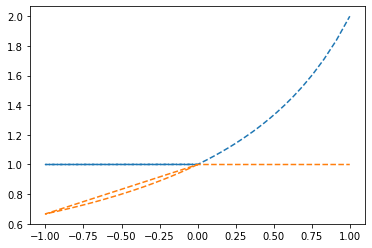

In [62]:
eigens = np.array(eigens)

plt.plot(eigens[:,0],eigens[:,1],'--')
plt.plot(eigens[:,0],eigens[:,2],'--')

In [42]:
np.absolute(np.linalg.eigvals(np.linalg.inv(A)))

array([1.        , 0.66666667, 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        ])

In [87]:
dx = [-1,0,1]
eX,eY = np.meshgrid(dx,dx)
e = np.array([eX.ravel(),eY.ravel()]).T

eL = np.linalg.norm(e, axis=1)

wE = np.zeros_like(w)
wE[eL==0] = 16/36.
wE[eL==1] = 4/36.
wE[eL>1] = 1/36.


In [258]:



N = 5
psi = np.linspace(0,2*np.pi,N)
Psi_s = np.array(np.meshgrid(psi,psi)).reshape(2,N**2).T

u_s = np.array([np.sin(psi), np.cos(psi)]).T

eigensU_Tau = list()

#for umag in np.linspace(0.01,1,10):
for lam in np.linspace(-2,0,10):
    for tau in np.linspace(0.4,2,10):
        max_eigen = 0
        max_eigen_euler = 0
        max_eigen_heun = 0
        max_eigen_trapez = 0
        for u in u_s:
            for Psi in Psi_s:

                dt = 1
                p = np.ones_like(w) # zero velocity
                #p = 1. + e.dot(umag*u)/3.

                Gamma = np.zeros((9,9),dtype=complex)

                for i in range(9):
                    for j in range(9):
                        if i == j: Gamma[i,j] = 1 - dt/(tau)
                        Gamma[i,j] +=  wE[i]*p[i]*dt/(tau)
                        Gamma[i,j] *= np.exp(-1j*dt*(Psi.dot(e[i,:]))) 

                tmp =  np.max(np.absolute(np.linalg.eigvals(Gamma)))        
                
                if max_eigen < tmp:
                    max_eigen = tmp
                    
                Xi = np.zeros((9,9),dtype=complex)
                for i in range(9):
                    for j in range(9):
                        Xi[i,j] = np.exp(-1j*dt*(Psi.dot(e[i,:])))*dt*w[i]*lam
                                          
                tmp =  np.max(np.absolute(np.linalg.eigvals(Gamma+Xi)))        
                
                if max_eigen_euler < tmp:
                    max_eigen_euler = tmp
                    
                tmp =  np.max(np.absolute(np.linalg.eigvals(Gamma+(2+lam*dt)/2.*Xi)))        
                
                if max_eigen_heun < tmp:
                    max_eigen_heun = tmp                        
        
                A = np.eye(9,9)

                for i in range(9):
                    A[i,:] -= lam*w[i] / 2     
                    
                A = np.linalg.inv(A)
                tmp =  np.max(np.absolute(np.linalg.eigvals(A @ (Gamma+1/2.*Xi))) )
                if max_eigen_trapez < tmp:
                    max_eigen_trapez = tmp   
        eigensU_Tau.append((lam, tau, max_eigen, max_eigen_euler, max_eigen_heun, max_eigen_trapez))


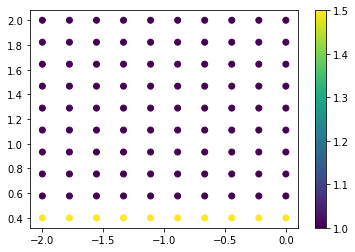

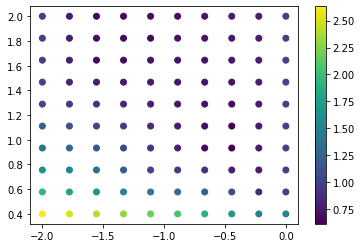

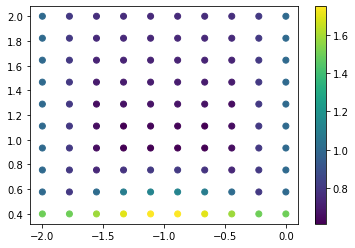

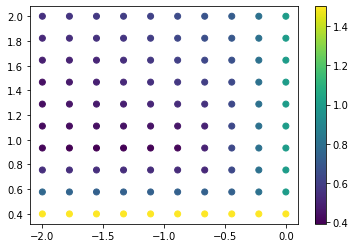

In [260]:
eigensU_Tau = np.array(eigensU_Tau)

plt.scatter(eigensU_Tau[:,0],eigensU_Tau[:,1], c=eigensU_Tau[:,2])
plt.colorbar()

plt.figure()
plt.scatter(eigensU_Tau[:,0],eigensU_Tau[:,1], c=eigensU_Tau[:,3])

maxVal = eigensU_Tau[:,3].reshape(10,10)
c_euler = np.array(measure.find_contours(maxVal, 1.0001)).T
#plt.plot(c_euler[1,:,0],c_euler[0,:,0],'r', lw=2)


plt.colorbar()

plt.figure()
plt.scatter(eigensU_Tau[:,0],eigensU_Tau[:,1], c=eigensU_Tau[:,4])
maxVal = eigensU_Tau[:,4].reshape(10,10)
c_heun = np.array(measure.find_contours(maxVal, 1.0001)).T
#plt.plot(c_euler[1,:,0],c_euler[0,:,0],'r', lw=2)


plt.colorbar()


plt.figure()
plt.scatter(eigensU_Tau[:,0],eigensU_Tau[:,1], c=eigensU_Tau[:,5])
maxVal = eigensU_Tau[:,5].reshape(10,10)
c_trapez = np.array(measure.find_contours(maxVal, 1.0001)).T
#plt.plot(c_euler[1,:,0],c_euler[0,:,0],'r', lw=2)

plt.colorbar()

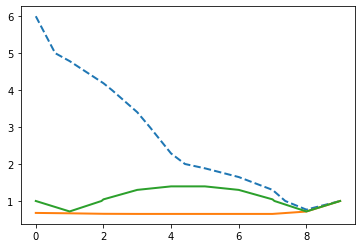

In [267]:
plt.plot(c_euler[0,:,0],c_euler[1,:,0],'--' ,lw=2)
plt.plot(c_trapez[0,:,0],c_trapez[1,:,0], lw=2)
plt.plot(c_heun[0,:,0],c_heun[1,:,0], lw=2)


In [266]:
c_euler[0,:,0]

array([0.        , 0.57174107, 1.        , 2.        , 2.25256482,
       3.        , 3.37094529, 4.        , 4.41210097, 5.        ,
       6.        , 7.        , 7.37615513, 8.        , 9.        ])